## Getting Started 
### Before we begin, we need to install some additional modules. Here's how: 

#### Open a new terminal in jupyter lab and activate your conda environment (conda activate marn5895)

#### Then: 




In [ ]:
pip install -U scikit-learn 

#### And: 

In [ ]:
conda install -c anaconda statsmodels

#### Copy argo data from the shared space to your current folder 

In [ ]:
cp /shared/marn5895/LJB_AJC/data/*.nc .

## Visualizations using multiple floats and profiles

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean as cmo
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import gsw
import pandas as pd

In [5]:
### will need to edit the path to match your file structure ###

natl ='/home/ajc20023/RCcourse/finalproject/indivfloats/GL_PR_PF_4903365.nc'
nwatl ='/home/ajc20023/RCcourse/finalproject/indivfloats/GL_PR_PF_5906438.nc'
equatl ='/home/ajc20023/RCcourse/finalproject/indivfloats/GL_PR_PF_6903874.nc'
swatl ='/home/ajc20023/RCcourse/finalproject/indivfloats/GL_PR_PF_5905985.nc'
seatl ='/home/ajc20023/RCcourse/finalproject/indivfloats/GL_PR_PF_5906246.nc'

In [2]:
natl = '/home/lab19005/FinalProject/Argo/GL_PR_PF_4903365.nc'
nwatl = '/home/lab19005/FinalProject/Argo/GL_PR_PF_5906438.nc'
equatl = '/home/lab19005/FinalProject/Argo/GL_PR_PF_6903874.nc'
swatl = '/home/lab19005/FinalProject/Argo/GL_PR_PF_5905985.nc'
seatl = '/home/lab19005/FinalProject/Argo/GL_PR_PF_5906246.nc'

In [3]:
natl = xr.open_dataset(natl)
nwatl = xr.open_dataset(nwatl)
equatl = xr.open_dataset(equatl)
swatl = xr.open_dataset(swatl)
seatl = xr.open_dataset(seatl)

#### Open one of the datasets and see what we have to work with 

In [4]:
natl

<xarray.Dataset>
Dimensions:                   (TIME: 20, LATITUDE: 20, LONGITUDE: 20, POSITION: 20, DEPTH: 511)
Coordinates:
  * TIME                      (TIME) datetime64[ns] 2021-08-13T14:06:32 ... 2...
  * LATITUDE                  (LATITUDE) float32 59.92 59.92 ... 57.87 57.87
  * LONGITUDE                 (LONGITUDE) float32 -39.42 -39.42 ... -46.02
Dimensions without coordinates: POSITION, DEPTH
Data variables: (12/43)
    TIME_QC                   (TIME) float32 ...
    POSITION_QC               (POSITION) float32 ...
    DC_REFERENCE              (TIME) object ...
    DIRECTION                 (TIME) object ...
    VERTICAL_SAMPLING_SCHEME  (TIME) object ...
    PRES                      (TIME, DEPTH) float32 ...
    ...                        ...
    NTAW_ADJUSTED_ERROR       (TIME, DEPTH) float64 ...
    PHPH                      (TIME, DEPTH) float64 ...
    PHPH_QC                   (TIME, DEPTH) float32 ...
    PHPH_ADJUSTED             (TIME, DEPTH) float64 ...
    PHPH_ADJUSTED_QC          (TIME, DEPTH) float32 ...
    PHPH_ADJUSTED_ERROR       (TIME, DEPTH) float64 ...
Attributes: (12/47)
    data_type:                      OceanSITES vertical profile
    format_version:                 1.4
    platform_code:                  4903365
    institution:                    Woods Hole Oceanographic Institution (WHOI)
    institution_edmo_code:          3844
    site_code:                       
    ...                             ...
    last_date_observation:          2021-11-11T04:59:42Z
    last_latitude_observation:      57.86600
    last_longitude_observation:     -46.01700
    date_update:                    2021-11-16T14:03:41Z
    history:                        2021-11-16T14:03:41Z : Creation
    data_mode:                      R

#### Where are these data from? 

In [7]:
# Get slice of ETOPO1 topography data from WHOI's GEOPORT thredds server
regional_extent = [-80,30,-60,65] #lonmin, lonmax, latmin, latmax 

regional_area = {
    'lon': [-80,30,30,-80,-80],
    'lat': [-60,-60,65,65,-60],
}

url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bathy = xr.open_dataset(url)
bathy = bathy.sel(lon=slice(regional_extent[0]-2,regional_extent[1]+2),
                  lat=slice(regional_extent[2]-2,regional_extent[3]+2)  
)

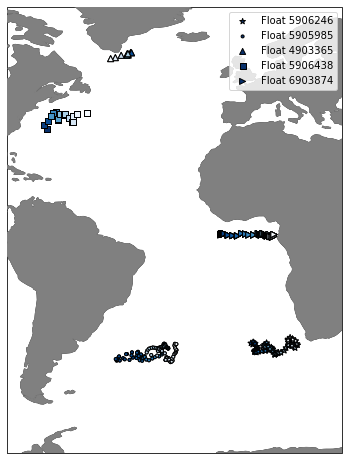

In [6]:
fig = plt.figure(figsize=(6,10))
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.coastlines()
ax.set_extent(regional_extent)
kw = {'cmap':'Blues_r',
     'edgecolor':'black'}
plt.scatter(x=seatl.LONGITUDE,y=seatl.LATITUDE,marker='*',c=seatl.TIME,**kw,label='Float 5906246')
plt.scatter(x=swatl.LONGITUDE,y=swatl.LATITUDE,marker='.',c=swatl.TIME,**kw,label='Float 5905985')
plt.scatter(x=natl.LONGITUDE,y=natl.LATITUDE,marker='^',c=natl.TIME,**kw,label='Float 4903365')
plt.scatter(x=nwatl.LONGITUDE,y=nwatl.LATITUDE,marker=',',c=nwatl.TIME,**kw,label='Float 5906438')
plt.scatter(x=equatl.LONGITUDE,y=equatl.LATITUDE,marker='>',c=equatl.TIME,**kw,label='Float 6903874')
plt.legend()
ax.add_feature(cartopy.feature.LAND,color='grey',zorder=5)
fig.savefig('map_floats.png',bbox_inches='tight',dpi=125)

#### Latitudinal cross-sections maps

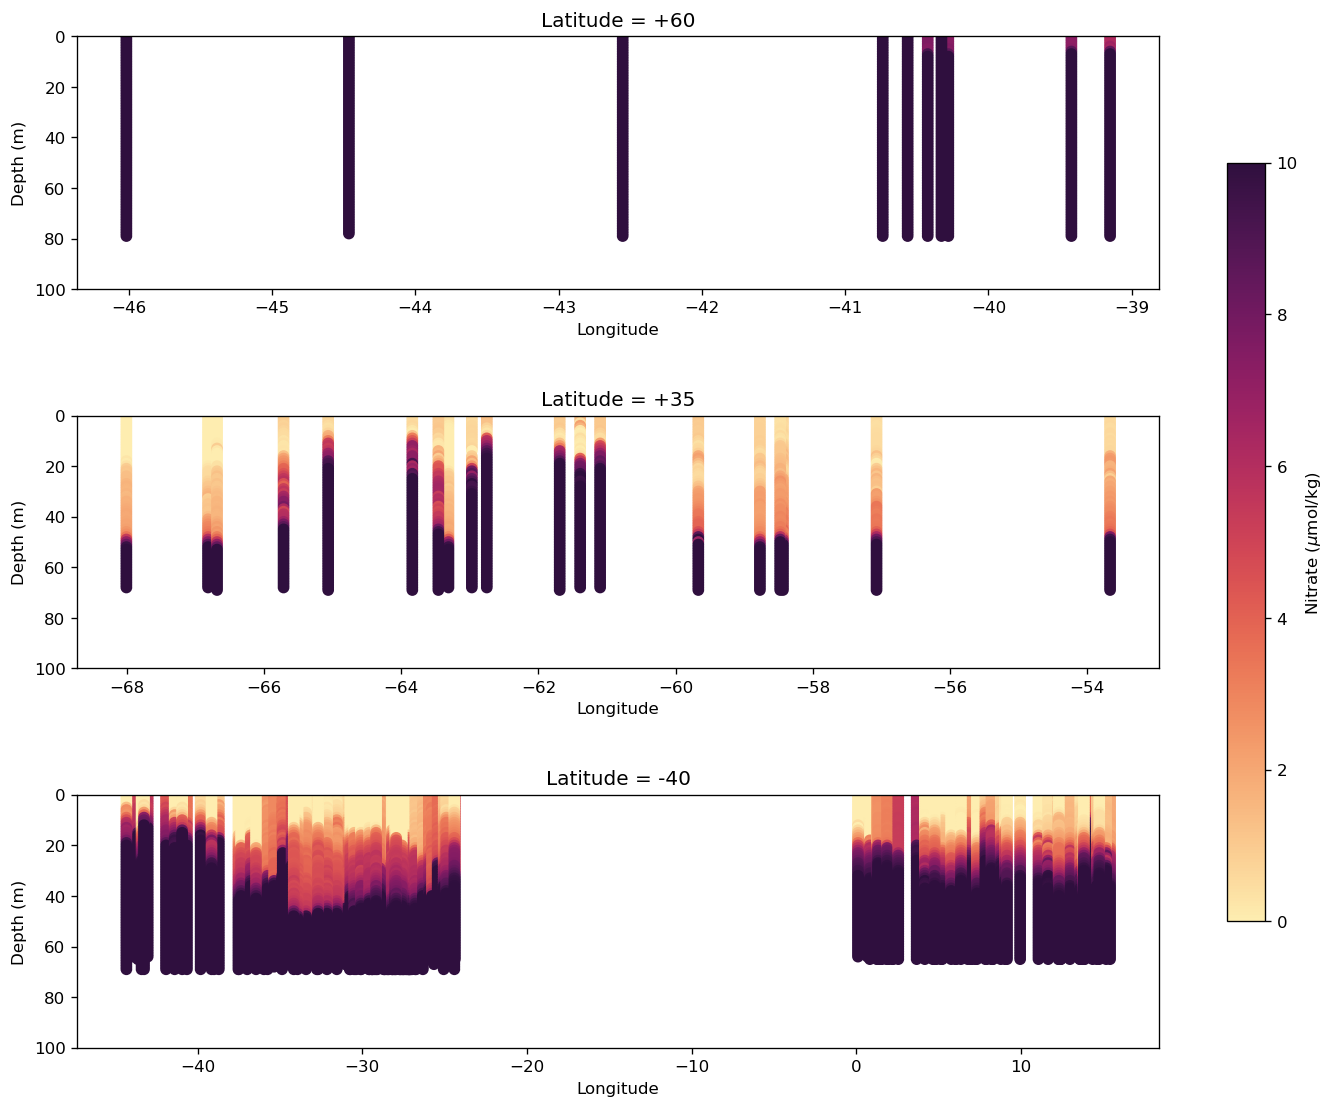

In [7]:
fig,ax = plt.subplots(nrows=3,ncols=1,dpi=120,figsize=(12,9))
fig.tight_layout()

kw1={'cmap':cmo.cm.matter,'vmin':0,'vmax':10}

# N. hemi temperate (~40N), float 5906438
Ntempdepth,Ntemplon = np.meshgrid(nwatl.DEPTH,nwatl.LONGITUDE)
im2=ax[1].scatter(Ntemplon,Ntempdepth,c=nwatl.NTAW_ADJUSTED,**kw1)
ax[1].set_ylim(100,0)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Depth (m)')
ax[1].set_title('Latitude = +35')

# N. hemi polar (~60N), float 4903365
polardepth,polarlon= np.meshgrid(natl.DEPTH,natl.LONGITUDE)
im3 = ax[0].scatter(polarlon,polardepth,c=natl.NTAW_ADJUSTED,**kw1)
ax[0].set_ylim(100,0)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Latitude = +60')

# S. hemi temperate (~40S), floats 5905985 & 5906246
Sdepth1,Slon1=np.meshgrid(swatl.DEPTH,swatl.LONGITUDE)
Sdepth2,Slon2=np.meshgrid(seatl.DEPTH,seatl.LONGITUDE)
ax[2].scatter(Slon1,Sdepth1,c=swatl.NTAW_ADJUSTED,**kw1)
ax[2].scatter(Slon2,Sdepth2,c=seatl.NTAW_ADJUSTED,**kw1)
ax[2].set_ylim(100,0)
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Depth (m)')
ax[2].set_title('Latitude = -40')

plt.subplots_adjust(hspace=0.5)
plt.colorbar(im2,ax=ax.ravel().tolist(),label='Nitrate ($\mu$mol/kg)',shrink=0.75)

fig.savefig('Nitrate by latitude.png',dpi=100,bbox_inches='tight')

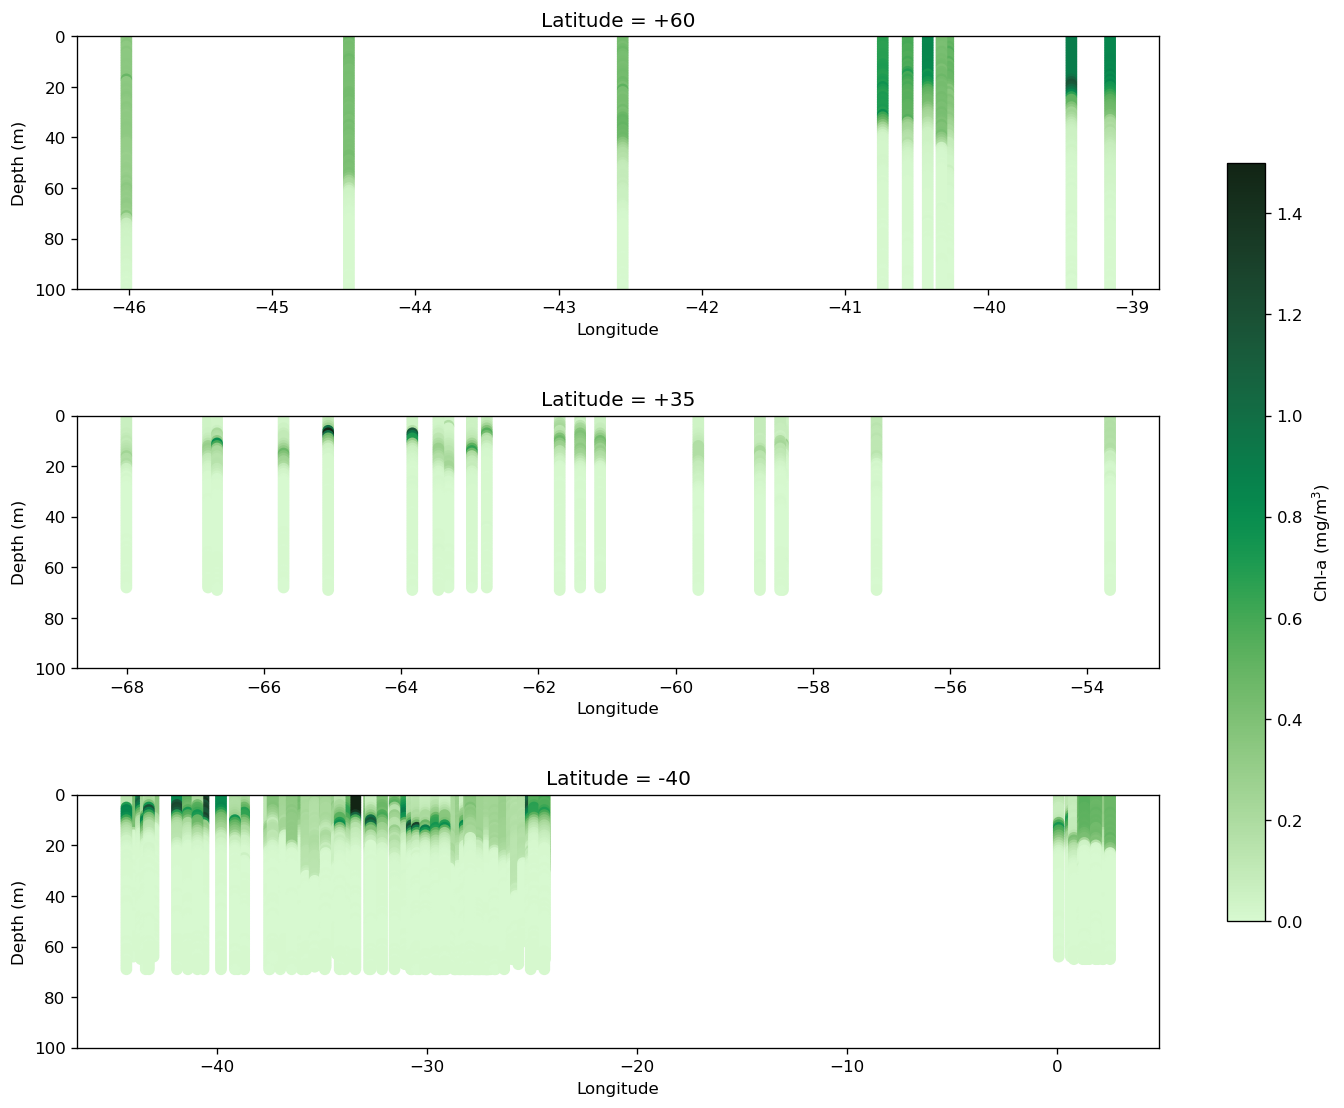

In [5]:
fig,ax = plt.subplots(nrows=3,ncols=1,dpi=120,figsize=(12,9))
fig.tight_layout()

kw1={'cmap':cmo.cm.algae,'vmin':0,'vmax':1.5}

# N. hemi temperate (~40N), float 5906438
Ntempdepth,Ntemplon = np.meshgrid(nwatl.DEPTH,nwatl.LONGITUDE)
im2=ax[1].scatter(Ntemplon,Ntempdepth,c=nwatl.CPHL_ADJUSTED,**kw1)
ax[1].set_ylim(100,0)
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Depth (m)')
ax[1].set_title('Latitude = +35')

# N. hemi polar (~60N), float 4903365
polardepth,polarlon= np.meshgrid(natl.DEPTH,natl.LONGITUDE)
im3 = ax[0].scatter(polarlon,polardepth,c=natl.CPHL_ADJUSTED,**kw1)
ax[0].set_ylim(100,0)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Latitude = +60')

# S. hemi temperate (~40S), floats 5905985 & 5906246
Sdepth1,Slon1=np.meshgrid(swatl.DEPTH,swatl.LONGITUDE)
Sdepth2,Slon2=np.meshgrid(seatl.DEPTH,seatl.LONGITUDE)
ax[2].scatter(Slon1,Sdepth1,c=swatl.CPHL_ADJUSTED,**kw1)
ax[2].scatter(Slon2,Sdepth2,c=seatl.CPHL_ADJUSTED,**kw1)
ax[2].set_ylim(100,0)
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Depth (m)')
ax[2].set_title('Latitude = -40')

plt.subplots_adjust(hspace=0.5)
plt.colorbar(im2,ax=ax.ravel().tolist(),label='Chl-a (mg/m$^3$)',shrink=0.75)

fig.savefig('Chl-a by latitude.png',dpi=100,bbox_inches='tight')

#### 3-D visualization

In [ ]:
from mpl_toolkits import mplot3d

Text(0.5, 0, 'Depth (m)')

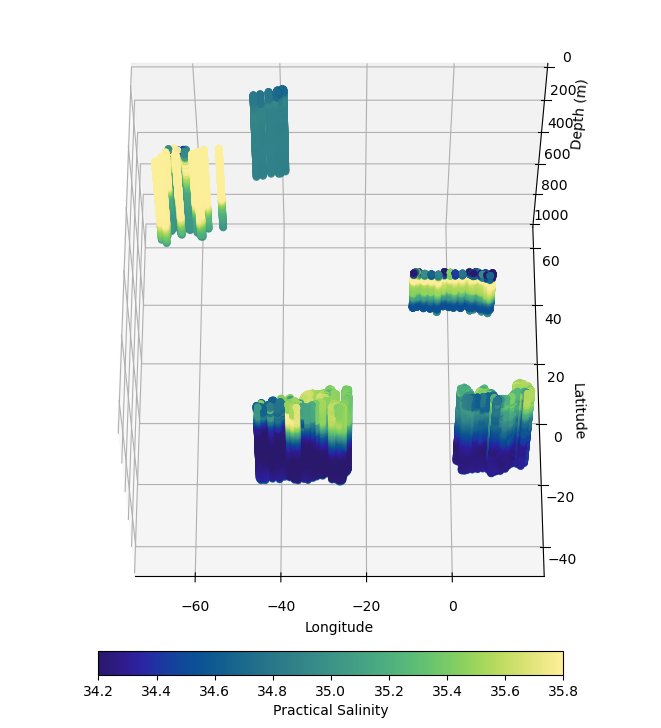

In [8]:
fig = plt.figure(figsize=(10,10),dpi=100)
ax = plt.axes(projection = '3d')
kw = {'cmap':cmo.cm.haline,'vmin':34.2,'vmax':35.8}

# use meshgrid to make depth & lat/lon the same size
polardepth,polarlon= np.meshgrid(natl.DEPTH,natl.LONGITUDE)
polardepth,polarlat = np.meshgrid(natl.DEPTH,natl.LATITUDE)

Ntempdepth,Ntemplon = np.meshgrid(nwatl.DEPTH,nwatl.LONGITUDE)
Ntempdepth,Ntemplat = np.meshgrid(nwatl.DEPTH,nwatl.LATITUDE)

eqdepth,eqlon = np.meshgrid(equatl.DEPTH,equatl.LONGITUDE)
eqdepth,eqlat = np.meshgrid(equatl.DEPTH,equatl.LATITUDE)

Sdepth1,Slon1=np.meshgrid(swatl.DEPTH,swatl.LONGITUDE)
Sdepth1,Slat1 = np.meshgrid(swatl.DEPTH,swatl.LATITUDE)

Sdepth2,Slon2=np.meshgrid(seatl.DEPTH,seatl.LONGITUDE)
Sdepth2,Slat2=np.meshgrid(seatl.DEPTH,seatl.LATITUDE)

# plotting polar float 4903365
im = ax.scatter3D(polarlon,polarlat,polardepth,c=natl.PSAL_ADJUSTED,**kw)
ax.set_zlim(1000,0)

#plotting northern hemi temperate float 5906438
im1 = ax.scatter3D(Ntemplon,Ntemplat,Ntempdepth,c=nwatl.PSAL_ADJUSTED,**kw)
ax.set_zlim(1000,0)

#plotting equatorial float 6903874
im2 = ax.scatter3D(eqlon,eqlat,eqdepth,c=equatl.PSAL,**kw)
ax.set_zlim(1000,0)

# plotting southern hemi temperate float 1 - 5905985
im3 = ax.scatter3D(Slon1,Slat1,Sdepth1,c=swatl.PSAL_ADJUSTED,**kw)
ax.set_zlim(1000,0)

# plotting southern hemi temperate float 2 - 5906246
im4 = ax.scatter3D(Slon2,Slat2,Sdepth2,c=seatl.PSAL_ADJUSTED,**kw)
ax.set_zlim(1000,0)

# rotate the view to match how we view things N-S and E-W
ax.view_init(60,270)

fig.colorbar(im,shrink=0.6,label = 'Practical Salinity',location='bottom',pad=0)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (m)')

fig.savefig('Sal 3D vis.png',dpi=100,bbox_inches='tight')

## Developing a linear regression to predict pH
#### Visually check for linearity as a first step

#### Temperature and pH

Text(0, 0.5, 'pH')

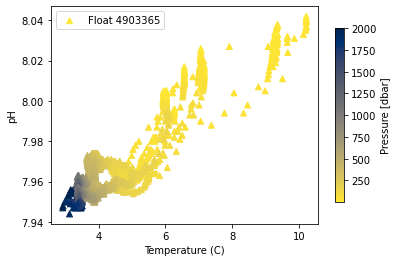

In [13]:
plt.figure()
im=plt.scatter(x=natl.TEMP_ADJUSTED,y=natl.PHPH_ADJUSTED,marker='^',c=natl.PRES_ADJUSTED,cmap='cividis_r',label='Float 4903365')
plt.legend()
plt.colorbar(im,shrink=0.8,
             label='Pressure [dbar]')
plt.xlabel('Temperature (C)')
plt.ylabel('pH')

Text(0, 0.5, 'pH')

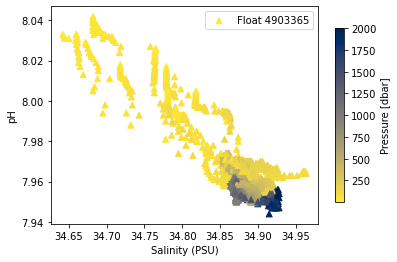

In [15]:
plt.figure()
im=plt.scatter(x=natl.PSAL_ADJUSTED,y=natl.PHPH_ADJUSTED,marker='^',c=natl.PRES_ADJUSTED,cmap='cividis_r',label='Float 4903365')
plt.legend()
plt.colorbar(im,shrink=0.8,
             label='Pressure [dbar]')
plt.xlabel('Salinity (PSU)')
plt.ylabel('pH')

Text(0, 0.5, 'pH')

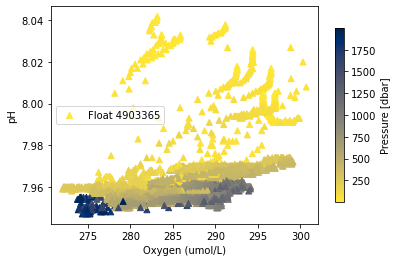

In [16]:
plt.figure()
im=plt.scatter(x=natl.DOX2_ADJUSTED,y=natl.PHPH_ADJUSTED,marker='^',c=natl.PRES_ADJUSTED,cmap='cividis_r',label='Float 4903365')
plt.legend()
plt.colorbar(im,shrink=0.8,
             label='Pressure [dbar]')
plt.xlabel('Oxygen (umol/L)')
plt.ylabel('pH')

## Linear Model example - pH from temperature

In [8]:
from sklearn import linear_model    # the linear model
import statsmodels.api as sm        # software package for statistics

### Calibrate using float 4903365 for which linearity has been confirmed

#### Define and manipulate independent & dependent variables

In [10]:
# ph, our dependent variable, to be predicted
ph = natl.PHPH_ADJUSTED.values    # isolate the variable from its xr dimensions
ph = ph.flatten()             # numpy function to change from 2D to 1D array
# temp, our independent variable, used to predict
temp = natl.TEMP_ADJUSTED.values
temp = temp.flatten()

#### Make the model

In [12]:
X = sm.add_constant(temp)    # this line is necessary to tell statsmodels to include a non-zero intercept
## here is the model syntax!
phmodel = sm.OLS(ph,X,missing='drop').fit()
print(phmodel.summary())    
# outputs a suite of stats such as RSQ, P, F, AIC, but in a text format

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 1.984e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        12:32:55   Log-Likelihood:                 18459.
No. Observations:                5099   AIC:                        -3.691e+04
Df Residuals:                    5097   BIC:                        -3.690e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9128      0.000   2.11e+04      0.0

In [54]:
## you can also get individual values such as the slope, intercept, p, RSQ, etc in string/array format
m = phmodel.params[1]
b = phmodel.params[0]
rsq = phmodel.rsquared
p = phmodel.pvalues
print('Model slope is',m)
print('Model intercept is',b)
print('Model RSQ is',rsq)
print('Model p-values are',p)  

Model slope is 0.012511549442497476
Model intercept is 7.912809174597255
Model RSQ is 0.7956027548249001
Model p-values are [0. 0.]


### Plot the data with a regression line 

Text(0.5, 0, 'Temperature ($^\\circ$C)')

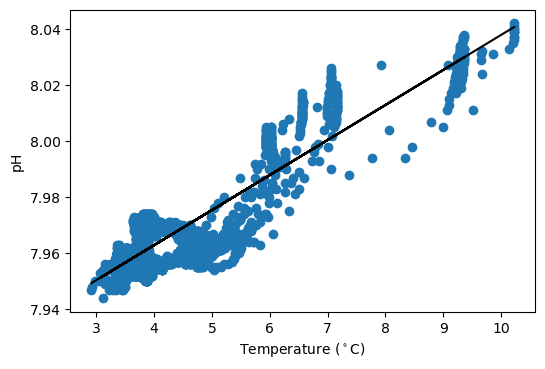

In [31]:
fig = plt.figure(dpi=100)
plt.scatter(temp,ph)
modelY = m*temp + b
plt.plot(temp,modelY,color='k',zorder=1)
plt.ylabel('pH')
plt.xlabel('Temperature ($^\circ$C)')

### Validate the model with another float 

Life was easy with the N. Atl. float because each temp had a corresponding pH. However, for this float, as with many Argo floats, pH and temp might be separated by time (within a few seconds/minutes) or depth (within a meter or two). Therefore, we will resample (for time) and then interpolate (for depth) to get corresponding temp & pH values for model validation.

In [37]:
equatl_resamp = equatl.resample(TIME='1H').mean()
equatl_int = equatl_resamp.interp(DEPTH = np.linspace(0,2200,440))

In [40]:
temp = equatl_int.TEMP.values
temp = temp.flatten()
ph_obs = equatl_int.PHPH.values
ph_obs = ph_obs.flatten()

# Apply the model to this float's data
ph_pred = m*temp + b


In [41]:
# Compare this float's pH observed vs predicted to see how the model did
X = sm.add_constant(ph_obs)
comp_model = sm.OLS(ph_pred,X,missing='drop').fit()
print(comp_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     419.1
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.39e-84
Time:                        12:48:53   Log-Likelihood:                 2210.7
No. Observations:                1906   AIC:                            -4417.
Df Residuals:                    1904   BIC:                            -4406.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5513      0.221     16.037      0.0

Text(0, 0.5, 'Predicted pH')

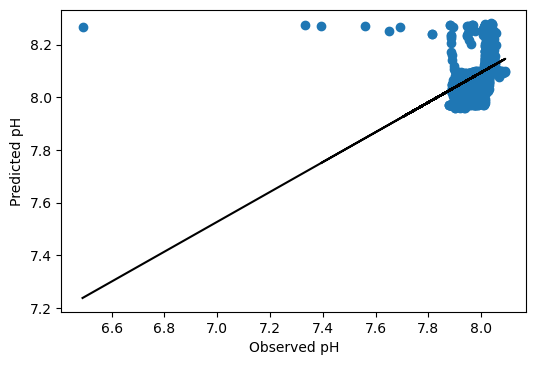

In [45]:
fit = plt.figure(dpi=100)
plt.scatter(ph_obs,ph_pred)
modelY= comp_model.params[1]*ph_obs + comp_model.params[0]
plt.plot(ph_obs,modelY,color='k',zorder=1)
plt.xlabel('Observed pH')
plt.ylabel('Predicted pH')

From this we can see that there are erroneous pH measurements below ~7.8 that are affecting the linear regression results. Let's clean that up.

In [51]:
ph_array = np.array([ph_obs,ph_pred])
ph_df = pd.DataFrame(ph_array)
ph_df = ph_df.T
ph_df = ph_df.dropna()
cleaned_df = ph_df[ph_df[0] >= 7.85]

In [52]:
# Repeat the comparison to see what's real
X = sm.add_constant(cleaned_df[0].values)
Y = cleaned_df[1].values
comp_model = sm.OLS(Y,X,missing='drop').fit()
print(comp_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     1684.
Date:                Wed, 08 Dec 2021   Prob (F-statistic):          5.14e-264
Time:                        12:55:02   Log-Likelihood:                 2630.1
No. Observations:                1898   AIC:                            -5256.
Df Residuals:                    1896   BIC:                            -5245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7700      0.240     -7.372      0.0

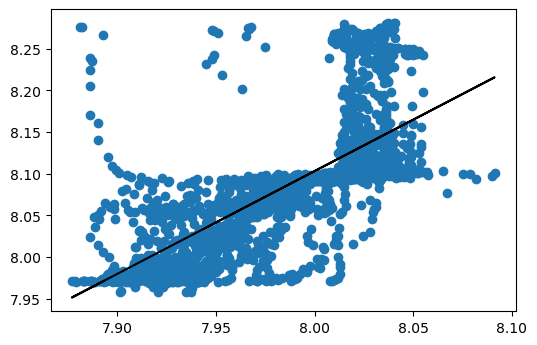

In [53]:
fit = plt.figure(dpi=100)
plt.scatter(cleaned_df[0],cleaned_df[1])
modelY = comp_model.params[1]*cleaned_df[0].values + comp_model.params[0]
plt.plot(cleaned_df[0].values,modelY,color='k',zorder=1)

## Multiple Linear Model equation 

In [17]:
## pull data from xarray and convert to pandas for this.
temp = natl.TEMP_ADJUSTED.values
temp = temp.flatten()

salt = natl.PSAL_ADJUSTED.values
salt = salt.flatten()

ph = natl.PHPH_ADJUSTED.values
ph = ph.flatten()

#put together to delete nans so that arrays are the same length for later

all = np.array([temp,salt,ph])
all = pd.DataFrame(all)
all = all.T
all

all = all.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
all

,0,1,2,3
0,9.363,34.687002,291.173014,8.038
1,9.360,34.687002,291.135014,8.037
2,9.351,34.687002,291.186014,8.037
3,9.346,34.688002,291.165014,8.037
4,9.342,34.688002,291.185014,8.037
...,...,...,...,...
9703,3.345,34.922002,274.591013,7.949
9704,3.266,34.922002,274.927013,7.948
9705,3.148,34.918002,274.908013,7.949
9706,3.117,34.926002,273.908013,7.954


In [18]:
#separate data again
training_ph = all.iloc[:,3]
training_ph

0       8.038
1       8.037
2       8.037
3       8.037
4       8.037
        ...  
9703    7.949
9704    7.948
9705    7.949
9706    7.954
9707    7.953
Name: 3, Length: 5089, dtype: float64

In [19]:
training_predvar = all.iloc[:,0:3]
training_predvar

,0,1,2
0,9.363,34.687002,291.173014
1,9.360,34.687002,291.135014
2,9.351,34.687002,291.186014
3,9.346,34.688002,291.165014
4,9.342,34.688002,291.185014
...,...,...,...
9703,3.345,34.922002,274.591013
9704,3.266,34.922002,274.927013
9705,3.148,34.918002,274.908013
9706,3.117,34.926002,273.908013


## Calculate VIF

#### VIF = $\frac{1}{1-R^2}$ 


In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [21]:
# VIF dataframe 
vif_data = pd.DataFrame()
vif_data["feature"] = training_predvar.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(training_predvar.values, i)
                          for i in range(len(training_predvar.columns))]
  
vif_data

,feature,VIF
0,0,17.163290
1,1,3027.942789
2,2,3056.264236


#### Predictor parameters do not pass VIF <10 

## Calculate MLR